# Import Librarys and Files

## Imports

### Add top level to the import path

In [1]:
import sys
import os

# Add the project root to sys.path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

### Import some classes/modules we'll be using

In [2]:
import ROOT as r
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from tqdm.notebook import tqdm 

import utils.utils as utils
import utils.plotting_utils as plotting_utils
from models.event import Event
from models.pattern import Pattern
from models.vertex import Vertex
from models.tracklet import Tracklet
from models.hit import Hit
from enums.default_stages import DefaultStages
from pipeline.pipeline import Pipeline

# Import the new pipeline stages
from pipeline.stages.event_input_stage import EventInputStage, InputContext
from pipeline.stages.event_init_stage import EventInitStage
from pipeline.stages.tracklet_stage import TrackletStage
from pipeline.stages.vertex_stage import VertexStage
from pipeline.stages.pattern_stage import PatternStage
from pipeline.stages.validation_stage import ValidationStage

# Import algorithm implementations
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
from algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

## Load Shared libraries to access methods of ROOT objects in python

In [3]:
PI_ROOT_DICT_PATH = "/home/jack/large_projects/simulation/install/lib/libPiRootDict.so" #Change to match system path
r.gSystem.Load(PI_ROOT_DICT_PATH)

0

## Load Simulation Data
This also contains what we need to reconstruct patterns. So it gives validation (true patterns) and a method to create our own pattern

In [4]:
file_truth_tree = "/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pimunu_tracklets_truth.root"  # CHANGE THIS
file_reco_tree = "/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pimunu_tracklets.root"  # CHANGE THIS


# Print creation time for each file
utils.print_file_creation_time(file_truth_tree)
utils.print_file_creation_time(file_reco_tree)


file_truth=r.TFile(file_truth_tree,"READ")
file_reco=r.TFile(file_reco_tree,"READ")


The file '/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pimunu_tracklets_truth.root' was created on: 2025-04-23 14:53:39
The file '/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/all_rec_pimunu_tracklets.root' was created on: 2025-04-22 14:38:30


## Get ROOT objects from our file
Making these more than once can cause memory leaks

In [5]:
tree = file_reco.Get("rec")
truth_tree = file_truth.Get("rec") #The truth tree is optional, if not provided the truth patterns in the reco tree will be used
geoHelper = file_reco.Get("GeoHeader")

# Older versions will have "PIMCGeoHelper"
#geoHelper = file_truth_pf.Get("PIMCGeoHelper")

# Create Python Structure from Event Data

## Initialize Pipeline

In [6]:
# Initialize a pipeline
pipeline = Pipeline()

# Register all stages in the pipeline
pipeline.register_stage(EventInputStage())
pipeline.register_stage(EventInitStage())
# NOTE: The truth tree is optional, if not provided the patterns already present in the reco tree will be considered "truth"
# However these are based on the reco tracklets, so some cases you may want a seperate file with truth tracklets --> truth patterns
pipeline.register_stage(TrackletStage(DefaultTrackletFormer(truth_tree=truth_tree)))
pipeline.register_stage(VertexStage(KMeansVertexFormer()))
pipeline.register_stage(PatternStage(DefaultPatternFormer()))
pipeline.register_stage(ValidationStage(TrackletGroupingValidator()))

print("Pipeline registered with stages:")
for stage_value, stage in pipeline.stage_manager.registered_steps.items():
    print(f"  {stage}")

Pipeline registered with stages:
  Stage(name='Load Event Input Data', stage_value=DefaultStages.INPUT)
  Stage(name='Initialize Event', stage_value=DefaultStages.EVENT_INIT)
  Stage(name='Form Tracklets', stage_value=DefaultStages.TRACKLETS)
  Stage(name='Form Vertices', stage_value=DefaultStages.VERTICES)
  Stage(name='Form Patterns', stage_value=DefaultStages.PATTERNS)
  Stage(name='Validate Event', stage_value=DefaultStages.VALIDATION)


## Step 1: Load Event Input Data

In [7]:
event_index = 0
input_context = InputContext(tree, geoHelper, event_index)

# Run the input stage
pipeline.run_stage(DefaultStages.INPUT, input_context)

print(f"\nStep 1 Complete - Input data loaded for event {event_index}")
print(f"Storage contents: {list(pipeline.get_storage().keys())}")
print(f"Current stage: {pipeline.get_current_stage()}")


Step 1 Complete - Input data loaded for event 0
Storage contents: ['tree', 'geo', 'entry_index']
Current stage: DefaultStages.INPUT


## Step 2: Initialize Event Object

In [8]:
pipeline.run_stage(DefaultStages.EVENT_INIT)

event = pipeline.get_event()
print(f"\nStep 2 Complete - Event initialized: {event}")
print(f"Current stage: {pipeline.get_current_stage()}")


Step 2 Complete - Event initialized: Event(id=0, no patterns, no tracklets, extra_info: 0 keys: [], is_valid=False)
Current stage: DefaultStages.EVENT_INIT


## Step 3: Create Tracklets for the Event

In [9]:
pipeline.run_stage(DefaultStages.TRACKLETS)

tracklets = pipeline.get_storage()["tracklets"]
event = pipeline.get_event()

print(f"\nStep 3 Complete - Tracklets formed: {len(tracklets)} tracklets")
print(f"Event extra info: {event.extra_info}")
print(f"Current stage: {pipeline.get_current_stage()}")


Step 3 Complete - Tracklets formed: 1 tracklets
Event extra info: {'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -13: 1}), 'patterns_truth': {0: [0, 1]}}}
Current stage: DefaultStages.TRACKLETS


## Step 4: Create Vertices from Tracklets


Step 4 Complete - Vertices formed: 2 vertices
Current stage: DefaultStages.VERTICES


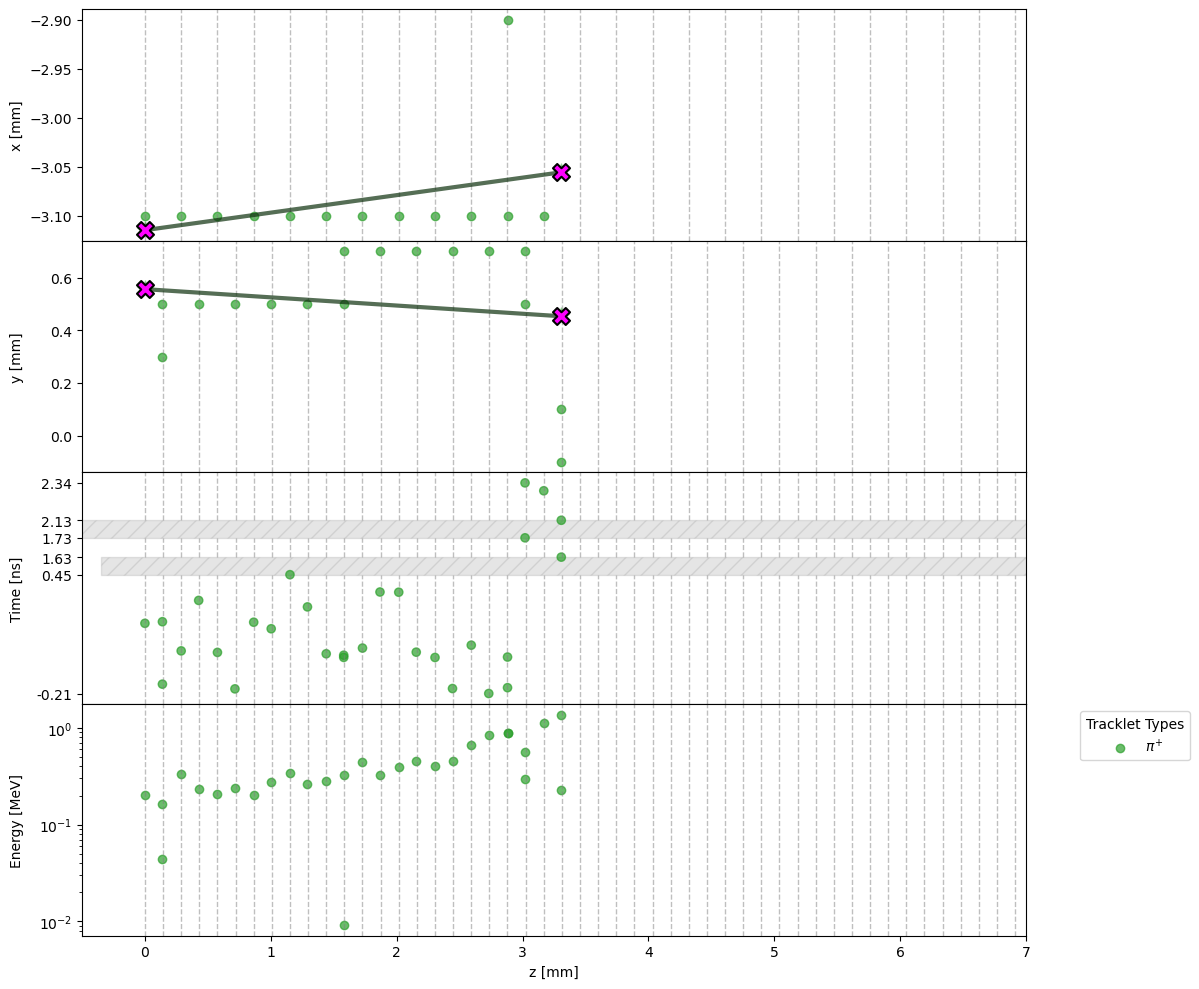

Event extra info: {'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -13: 1}), 'patterns_truth': {0: [0, 1]}}, 'vertex_algorithm_info': {'vertex_comparison': {'front_vertices': {Vertex(id=0, num_tracklets=1), Vertex(id=1, num_tracklets=1)}, 'back_vertices': {Vertex(id=0, num_tracklets=1), Vertex(id=1, num_tracklets=1)}, 'both_vertices': {Vertex(id=0, num_tracklets=1), Vertex(id=1, num_tracklets=1)}}, 'stats': {'front': {'BIC': 4.09579059285662, 'k': 2, 'centroids': array([[-3.05565528e+00,  0.00000000e+00,  3.30749995e+00],
       [-3.11465260e+00,  0.00000000e+00,  5.00000715e-04]]), 'iteration': 1, 'all_iterations': [{'bic': 16.632748091698055, 'k': 1, 'vertices': array([[-3.08515394,  0.        ,  1.65399998]]), 'iteration': 1}, {'bic': 16.632748091698055, 'k': 1, 'vertices': array([[-3.08515394,  0.        ,  1.65399998]]), 'iteration': 2}, {'bic': 16.632748091698055, 'k': 1, 'vertices': array([[-3.08515394,  0.        ,  1.65399998]]),

In [10]:
pipeline.run_stage(DefaultStages.VERTICES)

vertices = pipeline.get_storage()["vertices"]
event = pipeline.get_event()

print(f"\nStep 4 Complete - Vertices formed: {len(vertices)} vertices")
print(f"Current stage: {pipeline.get_current_stage()}")

# Reload and plot
reload(plotting_utils)
plotting_utils.plot_event(event)

# Show accumulated extra info
print(f"Event extra info: {event.extra_info}")

## Step 5: Create Patterns from Vertices

In [11]:
pipeline.run_stage(DefaultStages.PATTERNS)

patterns = pipeline.get_storage()["patterns"]
event = pipeline.get_event()

print(f"\nStep 5 Complete - Patterns formed: {len(patterns)} patterns")
print(f"Current stage: {pipeline.get_current_stage()}")

# Print patterns and the unique tracklets within each pattern along with vertex information
for pattern in patterns:
    print(f"\nPattern with {len(pattern.get_vertices())} vertices.")

    for vertex in pattern.get_vertices():
        tracklet_ids = [t.tracklet_id for t in vertex.get_tracklets()]
        print(f"  Vertex {vertex.vertex_id} (tracklet_ids={tracklet_ids})")

    print("  Unique Tracklets:")
    for tracklet in pattern.get_unique_tracklets():
        print(f"    {tracklet}")

print(f"\nEvent extra info: {event.extra_info}")



Step 5 Complete - Patterns formed: 1 patterns
Current stage: DefaultStages.PATTERNS

Pattern with 2 vertices.
  Vertex 0 (tracklet_ids=[0])
  Vertex 1 (tracklet_ids=[0])
  Unique Tracklets:
    Tracklet(id=0, particle_id=211, name=\pi^{+}, color=#2CA02C, e_id=2528, hits=29, extra_info_keys=['fit_results'], endpoints=(Point3D(x=-3.1146526011896283, y=0.5558980993867113, z=0.000500000715255744), Point3D(x=-3.055655276202041, y=0.45291479979947963, z=3.307499952316284)))

Event extra info: {'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -13: 1}), 'patterns_truth': {0: [0, 1]}}, 'vertex_algorithm_info': {'vertex_comparison': {'front_vertices': {Vertex(id=0, num_tracklets=1), Vertex(id=1, num_tracklets=1)}, 'back_vertices': {Vertex(id=1, num_tracklets=1), Vertex(id=0, num_tracklets=1)}, 'both_vertices': {Vertex(id=0, num_tracklets=1), Vertex(id=1, num_tracklets=1)}}, 'stats': {'front': {'BIC': 4.09579059285662, 'k': 2, 'centroids': array([[-

## Step 6: Validate Event Against Truth

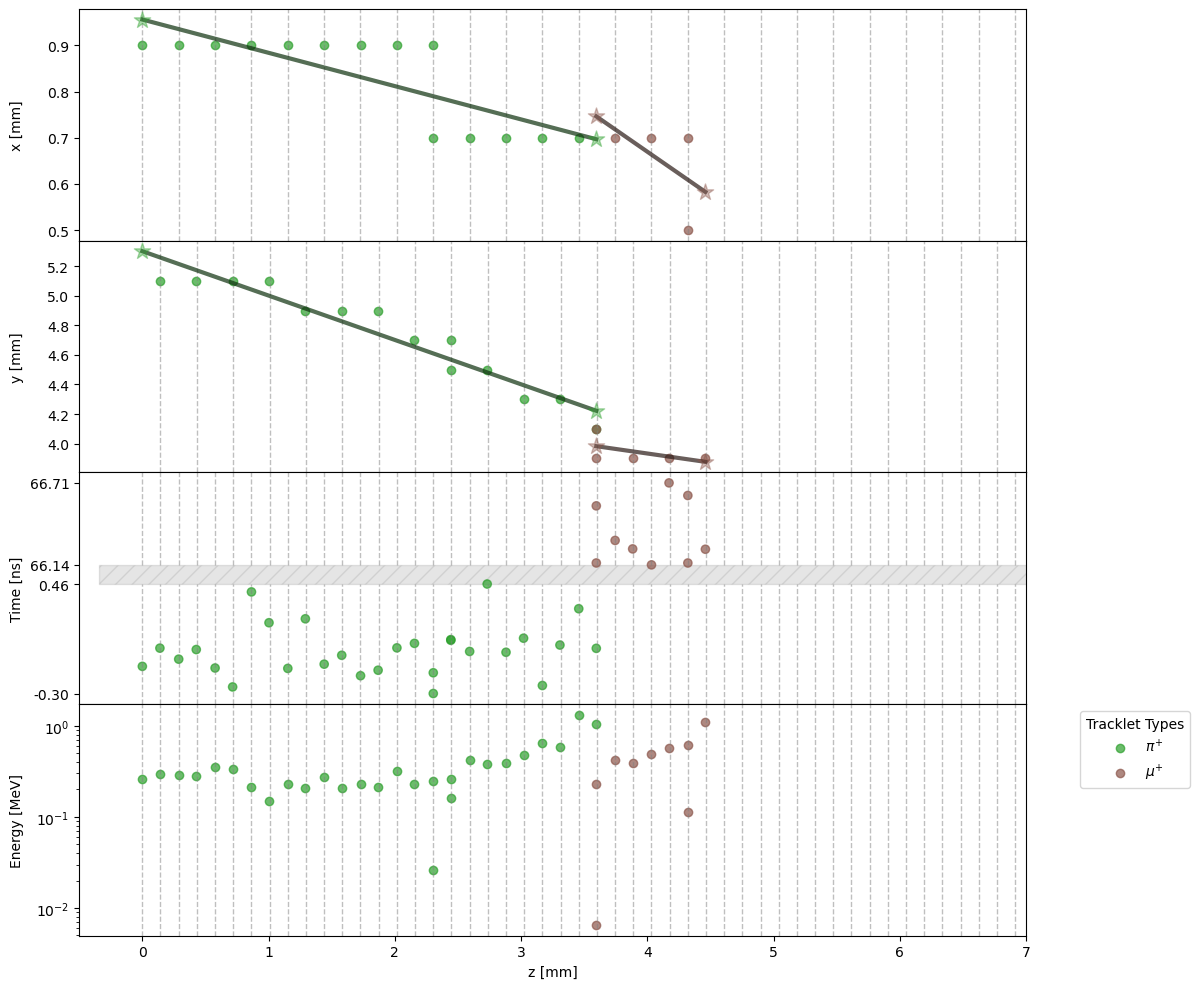


Step 6 Complete - Event validation: False
Final event: Event(id=23242, no patterns, 2 tracklets (sample IDs: [0, 1]), extra_info: 1 keys: ['tracklet_algorithm_info'], is_valid=False)
Current stage: DefaultStages.VALIDATION


In [15]:
pipeline.run_stage(DefaultStages.VALIDATION)
event = pipeline.get_event()


# Reload and plot
reload(plotting_utils)
plotting_utils.plot_event(event)

print(f"\nStep 6 Complete - Event validation: {event.is_valid}")
print(f"Final event: {event}")
print(f"Current stage: {pipeline.get_current_stage()}")

# Reconstruct Multiple Events

## Make cuts on the data set

In [13]:
# Number of events to process (set to None or a large number to process all events)
MAX_EVENTS = None
N_EVENTS = tree.GetEntries() if MAX_EVENTS is None else min(MAX_EVENTS, tree_pf.GetEntries())

use_pitar = True
use_in_fid_vol = True

nentries = tree.GetEntries()
all_events = []  # Store event IDs of all events that pass the initial cuts

for iEntry in tqdm(range(min(nentries, N_EVENTS)), desc="Processing Events"):

    patternFailed = False
    tree.GetEntry(iEntry)

    # SELECTIONS
    pitar = any(info.Has(r.kPitar) for info in tree.infoVec)

    if (not pitar) and use_pitar:
        continue

    in_fid_vol = True
    for tracklet in tree.trackletVec:
        for hit in tracklet.GetAllHits():
            vname = geoHelper.GetVolumeName(hit.GetVID()).Data()
            if 'atar' in vname:
                side = vname[11]
                if (side == "f" and abs(geoHelper.GetX(hit.GetVID())) > 8) or \
                   (side == "b" and abs(geoHelper.GetY(hit.GetVID())) > 8):
                    in_fid_vol = False

    if (not in_fid_vol) and use_in_fid_vol:
        continue

    all_events.append(iEntry)

Processing Events:   0%|          | 0/58659 [00:00<?, ?it/s]

## Run Reconstruction on Events

In [14]:
# Create and register pipeline once outside the loop
pipeline = Pipeline()

pipeline.register_stage(EventInputStage())
pipeline.register_stage(EventInitStage())
pipeline.register_stage(TrackletStage(DefaultTrackletFormer()))
pipeline.register_stage(VertexStage(KMeansVertexFormer(planes_to_run={"front"})))
pipeline.register_stage(PatternStage(DefaultPatternFormer()))
pipeline.register_stage(ValidationStage(TrackletGroupingValidator()))

# Number of events to process (-1 means all)
N_EVENTS = -1

# Determine number of events and slice all_events accordingly
if N_EVENTS == -1 or N_EVENTS > len(all_events):
    events_to_process = all_events
else:
    events_to_process = all_events[:N_EVENTS]

# Preallocate output array with correct length
reconstructed_events = np.empty(len(events_to_process), dtype=object)

# Run reconstruction loop
with tqdm(total=len(events_to_process), desc="Reconstructing events") as pbar:
    for i, event_index in enumerate(events_to_process):
        input_context = InputContext(tree, geoHelper, event_index)
        pipeline.run(input_context)
        reconstructed_events[i] = pipeline.get_event()  # deepcopy of event
        pbar.update(1)


Reconstructing events:   0%|          | 0/44698 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Check/View Algorithm Performance

## Performance vs. Particle composition

### Performance categorized by reconstructed particle componsition
Sometimes tracklets exist in truth, but do not create a hit in the atar. As a result, we cannot always construct the true particle composition.

In [ ]:
reload(plotting_utils)
title = f"Pattern Reconstruction by Reconstructed Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = False, title =  title)

### Performance categorized by true particle componsition
We can tag each event with the true particle composition information and plot against that instead to also see performance based on true particle composition

In [ ]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = True, title =  title)

## Performance vs. True Number of Patterns

In [ ]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_patterns_summary(reconstructed_events, title =  None)